# Streamgraph Twitter
This notebook takes you through making a streamgraph from tweets contained in a .csv file.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes). 


- **nltk:** A leading platform for building Python programs to work with human language data.
- **string:** Contains a number of functions to process standard Python strings.
- **re:** Provides regular expression matching operations similar to those found in Perl.
- **os:** Provides a portable way of using operating system dependent functionality.
- **csv:** Implements classes to read and write tabular data in CSV format.
- **math:** Provides access to the mathematical functions defined by the C standard.
- **numpy:** The fundamental package for scientific computing with Python.
- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **scipy:** Open-source software for mathematics, science, and engineering. The SciPy library depends on NumPy, which provides convenient and fast N-dimensional array manipulation.
- **ggplot:** a Python implementation of the grammar of graphics.

In [2]:
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import re
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rankdata
from ggplot import *

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. We are doing this so you will not need to make changes in the code further down.

First we need to specify what file type our data is saved as. Generally when dealing with Twitter data it will be in either ".json" or ".csv" format. For this reason our notebook will only read in ".csv" or ".json" files. The first variable `fileType` is where you choose either ".csv" or ".json" for your `fileType`. So it should look like `fileType = ".csv"` or `fileType = ".json"`.

Your data can be contained in one file or many. Therefore, you need to state if you want to read in a single document or an entire directory. If you want to read in a single document, then set `singleDoc` equal to **True**. If you want to read in an entire directory of documents then set `singleDoc` equal to **False**.

The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to **True**. If you do not, then set `nltkStop` equal to **False**.

The `customStop` variable is for if you have a dataset that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do **NOT** need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopwords list.** If you have a list of your own then set `customStop` equal to **True**. If you do not have your own custom stopwords list then set `customStop` equal to **False**.

The `stopLang` variable is to choose the language of the nltk stopword list you wish to use. It is currently set to `"english"`. If you need a different language, simply change `"english"` to the anglicized name of the language you wish to use (e.g. "spanish" instead of "espanol" or "german" instead of "deutsch"). If you need to see the list of available languages in nltk simply remove the `#` from in front of `#print(" ".join(stopwords.fileids()))` and run the cell. A list of available languages will display below the cell. 

The `stopWords = []` is an empty list that will contain the final list of stop words to be removed form your dataset. What ends up in the list depends on whether you set `nltkStop` and/or `customStop` equal to **True** or **False** and if you add any additional words to the list.

The `interestedWords` variable is where you insert your words of interest. Make sure to put each word in quotes and separate them with a comma. Remember, you will see how often each word occurs in each chunk simultaneously, so too many words may make the graph hard to read.

The `freqDict` variable is an empty dictionary which will be filled with words and their frequencies further down in the code.

In [3]:
fileType = ".csv"
singleDoc = True
nltkStop = True
customStop = False
stopLang = "english"
stopWords = []
interestedWords = ['nra', 'gop', 'msdstrong']
freqDict = {}

#print(" ".join(stopwords.fileids()))

#### File paths
Here we are saving different file paths as variables that we need in our code. We again do this so you will not need to make as many changes to the code later. 

First we use the `os` package above to find our `['HOME']` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` file path with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one, or we may need to access a file in this directory, but need to navigate to another folder to access other data. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` file path to other folder names that lead to a folder where we will want to save any output generated by this code. We again will change the file names for the output in the appropriate cells down below. We save this file path as the variable `dataResults`.

Lastly, we use the file path from `dataHome` to point to the directory where our data is stored and save that as `dataRoot`. Notice though that this is dependent upon whether you chose `".json"` or `".csv"` as your `fileType` above.

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")
if fileType == ".csv":
    dataRoot = os.path.join(dataHome, "twitter", "CSV", "parkland")
else:
    dataRoot = os.path.join(dataHome, "twitter", "JSON")

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the nltk stopwords list to the empty list named `stopWords`. You should already have chosen your language above, so there is no need to do that here.

If you wish to add additional words to the `stopWords` list, add the word in quotes to the list in `stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add'])`.

In [5]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))
    
    stopWords.extend(['amp','rt', 'xo_karmin_ox', 'neveragain', 'ð', 'â', 'ï', 'emma4change'])

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in `customStop` above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct path order, always putting the file name including the file extension ('.txt') last.

In [6]:
if customStop is True:
    stopWordsFilepath = os.path.join(dataHome, "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Functions
We need to create a few functions in order to calculate and create a wordcloud. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Read a .csv file

This function gives parameters and statements for how to read a '.csv' file. First notice we have an `if` statement to start. This function will only be saved to memory if we specified our `fileType` as `".csv"` above. Otherwise it will go on to the next cell of code.

As far as the function, we are incluidng that we want the reader to encode in utf-8 and ignore any errors from non-utf-8 characters. This is needed for social media due to the use of emojis and other abnormal characters. Then we tell Python to seperate the lines using a comma as the delimiter. Next we add the lines as rows in a column. Finally, we return the the content starting with row 1, not row 0, as row 0 is the header.

In [7]:
if fileType == ".csv":
    def readTweets(filepath, textColIndex, encoding = 'utf-8'):

        with open(filepath, encoding = encoding) as f:

            reader = csv.reader(f, delimiter = ',', quotechar = '"')

            content = []
            for row in reader: 
                content.append(row[textColIndex])

            # skip header
            return content[1 : ]

#### Read a .json file

This function gives parameters and statements for how to read a '.json' file. First notice we have an `if` statement to start. This function will only be saved to memory if we specified our `fileType` as `".json"` above. Otherwise it will go on to the next cell of code.

As far as the function, we are incluidng that we want the reader to encode in utf-8 and ignore any errors from non-utf-8 characters. This is needed for social media due to the use of emojis and other abnormal characters. Then we use the `loads` function form the `json` package. This will read in the '.json' file content as a string and save it to the empty `tweets = []` list. Next we convert the `tweets` list to a pandas database. Then we convert a single column to a list based on what is chosen for the `textColIndex` variable later on in the code. Finally, we return the content starting with row 1, not row 0, as row 0 is the header. 

In [8]:
if fileType == ".json":
    def readTweets(filepath, textColIndex, encoding = 'utf-8', errors = 'ignore'):
        
        with open(filepath, encoding = encoding, errors = errors) as jsonData:
            tweets = []
            for line in jsonData:
                tweets.append(json.loads(line))
        tweet = pd.DataFrame(tweets)
        content = tweet[textColIndex].tolist()

        return content[1 : ]

#### Text Cleaning
The first function does some text cleaning for us and requires the parameter: text (as in what text are you cleaning).

Now we come to the statements to be executed. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. Next we remove URLs by removing any text that starts with 'http' and ending with a space. Then we split the text into individual words. Next we remove any empty space, digits, stopwords, and punctuation. Finally, we return a list of cleaned words.

In [17]:
def clean(text):
    
    text = text.strip().lower()
    
    tweets = re.sub(r"http\S+", "", text)
    
    tokens = re.split(r'\W+', tweets )
    
    # remove empty string
    tokens = [t for t in tokens if t]
    
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    
    # built-in stop words list
    tokens = [t for t in tokens if t not in stopWords]
        
    # remove punctuation
    puncts = list(string.punctuation)
    puncts.append('--')

    tokens = [t for t in tokens if t not in puncts]

    return tokens

### Read in the tweets

Here we read in the tweets and break them up into chunks of a specified number of tweets. The first two lines, the textColIndex line, and the numTweetsPerBlock line are where you are going to make your changes. 

The first line assigns the file path to the directory where your .csv file is stored and is assigned to the variable 'root'. 

The next line points to the file itself by name and is assigned to the variable 'tweetFile'. 

The textColIndex line is where you point to the column in your .csv file that contains the actual text of the tweets. Right now we have it set for the 3rd column, which is 2 in Python since Python starts counting at 0. So, the first column is 0, the second column is 1, and the third column is 2. Set this number to the what ever column in from the left contains your tweets. 

The numTweetsPerBlock line is where you decide how many tweets you want per chunk. We have it set at 1000, but if you only have 500 tweets, you'll want to change this number. 

These four lines are the only ones you will most likely need to change.

In [18]:
tweetFile = 'neverAgain.csv'
textColIndex = 2
encoding = 'ISO-8859-1'
numTweetsPerChunk = 1000

if singleDoc is True:
    
    filepath = os.path.join(dataRoot, tweetFile)

    tweets = readTweets(filepath, textColIndex, encoding)

    print('Read {} tweets'.format(len(tweets)))

    numberChunks = int(math.ceil(len(tweets) / numTweetsPerChunk))

    print('Tweets per chunk: {}, # chunks is {}'.format(numTweetsPerChunk, numberChunks))

    chunks = []

    for i in range(numberChunks - 1):

        chunks.append(tweets[i * numTweetsPerChunk : (i + 1) * numTweetsPerChunk])

    chunks.append(tweets[(i + 1) * numTweetsPerChunk : ])
else:

    for root, subdirs, files in os.walk(dataRoot):
        
        for filename in files:
            
            # skip hidden file
            if filename.startswith('.'):
                continue
            
            dataFilepath = os.path.join(root, filename)
            
            content = readTweets(dataFilepath, textColIndex, encoding)
            tweets = '\n'.join(content)
            
            print('Read {} tweets'.format(len(tweets)))

            numberChunks = int(math.ceil(len(tweets) / numTweetsPerChunk))

            print('Tweets per chunk: {}, # chunks is {}'.format(numTweetsPerChunk, numberChunks))

            chunks = []

            for i in range(numberChunks - 1):

                chunks.append(tweets[i * numTweetsPerChunk : (i + 1) * numTweetsPerChunk])

            chunks.append(tweets[(i + 1) * numTweetsPerChunk : ])

Read 50645 tweets
Tweets per chunk: 1000, # chunks is 51


### Load in custom stopwords

There are two places to make adjustments in this block. First, you will want to change the filepath to point to your own personal custom stopword list. The second place to make changes is where it says lines.extend. The words in quotes in the brackets are words being added to the stopword list. Simply add words you want removed in quotes and separated by a comma. The rest will most likely not need to be changed.

In [21]:
tokenBlocks = []

for c in chunks:
    
    blocks = ' '.join(c)
    
    words = word_tokenize(blocks)
    
    words = clean(str(words))
    tokenBlocks.append(words)

### Pick words of interest
Here we decide what words we are most interested in seeing in the streamgraph. Just add any words with quotes and separated by a comma. There is no limit to how many words you can look at. However, at some point the graph may become difficult to read if you put too many words, so keep that in mind.

In [22]:
# calculate frequency
for w in interestedWords:
    
    freqDict[w] = np.zeros(len(tokenBlocks)).tolist()
    
for idx, block in enumerate(tokenBlocks):
    
    for token in block:
        
        if token in freqDict:
            freqDict[token][idx] += 1

### Emulate R's stat_steamgraph in 'ggTimeSeries' package

This function is meant to emulate the stat_steamgraph function from the ggTimeSeries package in R. You will most likely not need to make any changes here. This function is creating a special data frame (kind of like an excel table) for ggplot to be able to read it in a way that it creates a streamgraph from the data.

In [23]:
def composeDataframe(freqDict, debug = False):

    if debug:
        df = pd.DataFrame(data = freqDict)
        print(df)
        print('\n' * 3)


    wordCol = []
    freqCol = []
    seqNum = []
    
    for word in freqDict:
        wordCol.extend([word] * len(freqDict[word]))
        freqCol.extend(freqDict[word])
        seqNum.extend(list(range(1, len(freqDict[word]) + 1)))

    dataDict = {"Term" : wordCol, "Freq" : freqCol, 'SeqNum' : seqNum}

    df = pd.DataFrame(data = dataDict)

    if debug:
        print(df)
        print('\n' * 3)

    rankdf = df.groupby(["Term"], as_index = False).agg({"Freq" : "std"}).rename(columns = {"Freq" : "Std"})

    if debug:
        print(df)
        print('\n' * 3)

    rankdf["StdRank"] = rankdata(rankdf["Std"], method = 'ordinal')

    if debug:
        print(rankdf)
        print('\n' * 3)

    for idx, row in rankdf.iterrows():

        if row["StdRank"] % 2 == 0:
            rankdf.at[idx, "StdRank"] = -row["StdRank"]


    if debug:
        print(rankdf)
        print('\n' * 3)

    df = df.merge(rankdf, on = 'Term')

    if debug:
        print(df)
        print('\n' * 3)

    df = df.sort_values(by = ['SeqNum', 'StdRank'])

    if debug:
        print(df)
        print('\n' * 3)

    def f(x):

        x["cumsum"] = x["Freq"].cumsum()
        x["ymax"] = x["Freq"].cumsum() - x["Freq"].sum() / 2
        x["ymin"] = x["ymax"] - x["Freq"]

        return x


    df = df.groupby(["SeqNum"], as_index = False).apply(f)

    if debug:
        print(df)
        print('\n' * 3)
        
    return df


Now we apply the emulator data frame function from above to our corpus so we can plot the streamgraph in our next block of code. Again, it is unlikely that you will need to make changes here.

In [24]:
df = composeDataframe(freqDict)

### Plot the Streamgraph

For the code below, you will only need to make changes to five lines of code. The first is where it says 'scale_fill_brewer'. You may want to change the palette color to something else besides 'Dark2' (with the quotes). Some color options can be found [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf) under RColorBrewer. Next you will want to change the xlab, ylab, and ggtitle lines to match your data. The xlab and ylab is where you can change the labels of the x and y axis. The size changes the font size and vjust changes the distance from the graph the label appears. Finally, you will want to change the file path in plt.savefig to match where you want a .png of the graph to be saved and what you want to name the file. Once you've made your changes, you're ready to plot your graph!

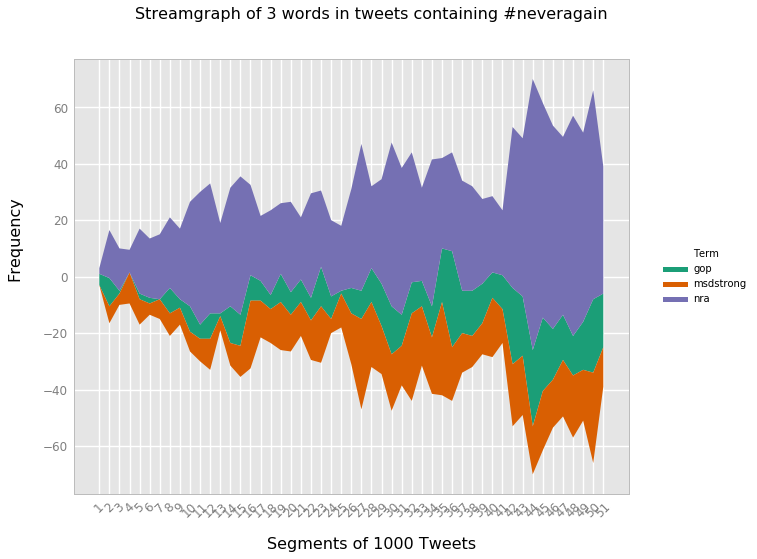

In [25]:
streamTwitterOutput = "streamgraphTwitter.svg"
p = ggplot(df, aes(x = 'SeqNum', ymin = 'ymin', ymax = 'ymax', y = 'Freq', group = 'Term', fill = 'Term')) +\
    geom_ribbon() + \
    theme(axis_text_x = element_text(angle = 45, hjust = 1)) + \
    scale_fill_brewer(type = 'qual', palette = 'Dark2') + \
    xlab(element_text(text = "Segments of 1000 Tweets", size = 16, vjust = -0.02)) + \
    ylab(element_text(text = "Frequency", size = 16)) + \
    scale_x_continuous(breaks = list(range(1, len(tokenBlocks) + 1))) + \
    ggtitle(element_text(text = "Streamgraph of 3 words in tweets containing #neveragain", size = 16))
p.make()
plt.savefig(os.path.join(dataResults,streamTwitterOutput), width = 14, height = 8, dpi = 800)

plt.show()

## VOILA!!